# 🧠 Testing with Concept Activation Vectors (TCAV)  
**Hands-On Tutorial Notebook – ECML PKDD 2025 ‘An Overview to
Concept-based Explainable AI’**

*Based on*: Kim *et al.* [Interpretability Beyond Feature Attribution: Quantitative Testing with Concept Activation Vectors (TCAV)](https://proceedings.mlr.press/v80/kim18d/kim18d.pdf), ICML 2018.

*Official repo*: https://github.com/tensorflow/tcav  

<a target="_blank" href="https://colab.research.google.com/github/cxai-mechint-htutorial-kdd2025/cxai-mechint-htutorial-kdd2025.github.io/blob/main/notebooks/01_tcav.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

> This tutorial builds upon the [Captum TCAV tutorial](https://captum.ai/tutorials/TCAV_Image), adapting and extending it with additional examples.

---

### 🌟 What you will learn
1. Understand and apply **TCAV** to interpret image classifiers.
2. Use concepts to quantify their influence on predictions.

**Estimated runtime**: ≈ 20 min using Colab (cpu).


## 🗺️ Notebook RoadMap
1. ⚙️ **Environment Setup**
2. 🧹 **Dataset Preparation**
3. 🧠 **Define Concepts & Collect Activations**
4. 🧮 **Define Model**
5. 📈 **Run TCAV & Interpret Results**
6. 🖼️ **In-depth analysis of concept influence**


![TCAV Pipeline](https://github.com/cxai-mechint-htutorial-kdd2025/cxai-mechint-htutorial-kdd2025.github.io/blob/main/img_notebooks/tcav.jpg?raw=true)

# 1. ⚙️ Environment Setup

:👉🏻 In this step, you will set up the environment by cloning the repo and installing and importing the necessary dependencies for running TCAV.


In [ ]:
import os

is_colab = 'google.colab' in str(get_ipython())
current_dir = os.getcwd()

if is_colab:
    # Clone tutorial repo if not present
    tutorial_repo = os.path.join(current_dir, 'hands-on-cxai-ecml-pkdd.git')
    if not os.path.exists(tutorial_repo):
        !git clone https://github.com/overview-cxai-tutorial-ecml-pkdd-2025/hands-on-cxai-ecml-pkdd.git

    # Install required packages
    !pip install captum

# If you are running the notebook locally, please ensure to have installed the captum library
else:
  try:
      import captum
  except ImportError as e:
      print(f"Error importing module: {e}. Please ensure that you installed it or do it with '!pip install captum'")

**If you are running this notebook in Colab, please restart your runtime now (Runtime --> Restart session). This ensures that all installed packages and configurations take effect before proceeding.**

In [ ]:
import numpy as np
import os, glob

import matplotlib.pyplot as plt

from PIL import Image

from scipy.stats import ttest_ind

# ..........torch imports............
import torch
import torchvision

from torch.utils.data import IterableDataset, DataLoader
from torchvision import transforms

#.... Captum imports..................
from captum.attr import LayerGradientXActivation, LayerIntegratedGradients

from captum.concept import TCAV
from captum.concept import Concept

from captum.concept._utils.data_iterator import dataset_to_dataloader, CustomIterableDataset
from captum.concept._utils.common import concepts_to_str


# 2. 🧹 Dataset Preparation

In this step, we prepare the dataset by defining key preprocessing utilities used throughout the TCAV workflow.

You will:

* **Normalize images** using the standard **ImageNet mean and standard deviation**, ensuring compatibility with pretrained models.
* **Resize and crop images** to a fixed input size (`224x224`) using a composed transformation pipeline.
* **Load image tensors** from disk and convert them into model-ready inputs.
* Define **helper functions**:

  * `transform(img)` – applies resizing, cropping, and normalization.
  * `get_tensor_from_filename(filename)` – loads and processes a single image.
  * `load_image_tensors(class_name, ...)` – loads and processes all images in a concept class.

These utilities are crucial for converting your raw concept and random examples into a format suitable for feature extraction and TCAV analysis.


In [ ]:
# Normalize the image
def transform(img):

    return transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            ),
        ]
    )(img)


In [ ]:
# Helpers
def get_tensor_from_filename(filename):
    img = Image.open(filename).convert("RGB")
    return transform(img)


def load_image_tensors(class_name, root_path='imagenet_classes', transform=True):
    path = os.path.join(root_path, class_name)
    filenames = glob.glob(path + '/*.jpg')

    tensors = []
    for filename in filenames:
        img = Image.open(filename).convert('RGB')
        tensors.append(transform(img) if transform else img)

    return tensors


# 3. 🧠 Define Concepts & Collect Activations

In this step, you will define and assemble the **concepts** used in **TCAV** and visualize example images from each concept class. These concepts serve as the basis for analyzing model behavior.

You will:

* **Dowload the concepts**

* **Define the** `assemble_concept(...)` **function** that:

  * Loads images from a concept folder.
  * Converts them to tensors using the previously defined transform.
  * Wraps them into a `Concept` object using a dataloader.

* **Instantiate Concept objects** using curated image folders from the `concepts/` directory. These include:

  * **Texture-based concepts** like `striped`, `zigzagged`, `banded`, and `dotted`, extracted from the [Broden dataset](https://netdissect.csail.mit.edu/broden1_224).
  * **Color-based concepts** like `white`, `red`, `purple`, etc. These color-based concepts are created through `matplotlib`. `**You can find the code in the repo at utils/color_concepts_gen.py. **`
  * **Random concepts** (`random_0`, `random_1`, …) consisting of images not associated with the main task class (e.g., zebra), used as negative controls.

* **Visualize a few sample images** from both **concept** and **random** classes to qualitatively inspect their content.

These assembled concept datasets are a key part of TCAV—they will later be used to extract **activations** and train **concept classifiers** that quantify their influence on predictions.

🔍 About the `Concept` class:
The `Concept` class in [Captum](https://captum.ai/tutorials/TCAV_Image) is a lightweight container for concept data.
It holds:
- a concept nam;
- an ID;
- a data_iter, which is a PyTorch iterator yielding preprocessed input tensors.

During TCAV analysis, these `Concept` objects are used to compute activations and train concept classifiers.



**Download the concepts**

In [ ]:
import os

is_colab = 'google.colab' in str(get_ipython())
current_dir = os.getcwd()

tutorial_repo = os.path.join(current_dir, 'hands-on-cxai-ecml-pkdd')
if is_colab:
    if not os.path.exists(tutorial_repo):
        print("Tutorial repository not found. Please ensure the repository is cloned.")
    data_dir = os.path.join(tutorial_repo, 'data')
else:
    data_dir = os.path.join(current_dir.replace("/notebooks", ""), 'data')

In [ ]:
concepts_path = os.path.join(data_dir, 'concepts_tcav')

if not os.path.exists(concepts_path):
  !wget https://dbdmg.polito.it/dbdmg_web/wp-content/uploads/2025/07/concepts_tcav.zip
  !unzip concepts_tcav.zip
  import shutil
  shutil.move('concepts_tcav', concepts_path)
  !rm concepts_tcav.zip

--2025-09-14 13:17:42--  https://dbdmg.polito.it/dbdmg_web/wp-content/uploads/2025/07/concepts_tcav.zip
Resolving dbdmg.polito.it (dbdmg.polito.it)... 130.192.163.163
Connecting to dbdmg.polito.it (dbdmg.polito.it)|130.192.163.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49324677 (47M) [application/zip]
Saving to: ‘concepts_tcav.zip’

concepts_tcav.zip     6%[>                   ]   3.16M  2.93MB/s               

In [ ]:
imagenet_data_path = os.path.join(data_dir, 'imagenet_classes')
if not os.path.exists(imagenet_data_path):
  !wget https://dbdmg.polito.it/dbdmg_web/wp-content/uploads/2025/07/imagenet_classes.zip
  !unzip imagenet_classes.zip
  import shutil
  shutil.move('imagenet_classes', imagenet_data_path)
  !rm imagenet_classes.zip

**Define the `assemble_concept(...)` function**

In [ ]:
def assemble_concept(name, id, concepts_path="data/tcav/image/concepts/"):
    concept_path = os.path.join(concepts_path, name) + "/"
    dataset = CustomIterableDataset(get_tensor_from_filename, concept_path)
    concept_iter = dataset_to_dataloader(dataset, batch_size=4)

    return Concept(id=id, name=name, data_iter=concept_iter)

**Instantiate Concept objects**

In [ ]:
# Texture based concepts
stripes_concept = assemble_concept("striped", 0, concepts_path=concepts_path)
zigzagged_concept = assemble_concept("zigzagged", 1, concepts_path=concepts_path)
dotted_concept = assemble_concept("dotted", 2, concepts_path=concepts_path)
banded_concept = assemble_concept("banded", 3, concepts_path=concepts_path)
chequered_concept = assemble_concept("chequered", 4, concepts_path=concepts_path)
honeycomb_concept = assemble_concept("honeycomb", 5, concepts_path=concepts_path)


# Color based concepts
white_concept = assemble_concept("white", 6, concepts_path=concepts_path)
black_concept = assemble_concept("black", 7, concepts_path=concepts_path)
red_concept = assemble_concept("red", 8, concepts_path=concepts_path)
yellow_concept = assemble_concept("yellow", 9, concepts_path=concepts_path)
magenta_concept = assemble_concept("magenta", 10, concepts_path=concepts_path)
purple_concept = assemble_concept("purple", 11, concepts_path=concepts_path)
green_concept = assemble_concept("green", 12, concepts_path=concepts_path)


# Random concepts
random_0_concept = assemble_concept("random_0", 13, concepts_path=concepts_path)
random_1_concept = assemble_concept("random_1", 14, concepts_path=concepts_path)

**Visualize a few sample images**

Let\'s visualize some samples from those concepts

In [ ]:
n_figs = 5
n_concepts = 5

fig, axs = plt.subplots(n_concepts, n_figs + 1, figsize = (25, 4 * n_concepts))

for c, concept in enumerate([stripes_concept, zigzagged_concept, dotted_concept, random_0_concept, random_1_concept]):
    concept_path = os.path.join(concepts_path, concept.name) + "/"
    img_files = glob.glob(concept_path + '*')
    for i, img_file in enumerate(img_files[:n_figs + 1]):
        if os.path.isfile(img_file):
            if i == 0:
                axs[c, i].text(1.0, 0.5, str(concept.name), ha='right', va='center', family='sans-serif', size=24)
            else:
                img = plt.imread(img_file)
                axs[c, i].imshow(img)

            axs[c, i].axis('off')


Output hidden; open in https://colab.research.google.com to view.

# 4. 🧮 Define Model

In this step, you’ll load and prepare the **GoogleNet model**, which will serve as the base classifier for TCAV analysis.

You will:

* **Load the pretrained GoogleNet model** from `torchvision`, which has been trained on the **ImageNet** dataset.
* **Switch the model to evaluation mode** using `model.eval()`, which is crucial for inference (disabling dropout, batch norm updates, etc.).
* **Inspect the model architecture** to decide where to extract concept-based explanations:

  * Print the **top-level layers** (excluding internal submodules).
  * Manually select a few layers (e.g., `inception3a`, `inception4a`, `inception5a`) to cover *different depths of the network*.

These selected layers will be used later to extract internal **activations**—the foundation for computing CAVs and directional derivatives in TCAV.

In [ ]:
model = torchvision.models.googlenet(pretrained=True)
model = model.eval()

Now let's identify which layers we would like to extract explanations for. Let's print all the layers in the network and let's extract three of these layers.


In [ ]:
for name, layer in model.named_modules():
    if len(name.split(".")) < 2: # we avoid submodules
        print(name)


conv1
maxpool1
conv2
conv3
maxpool2
inception3a
inception3b
maxpool3
inception4a
inception4b
inception4c
inception4d
inception4e
maxpool4
inception5a
inception5b
avgpool
dropout
fc


In [ ]:
# Select three layer across the architectures (from shallower to deeper) as strings
layers=['inception3a', 'inception4a', 'inception5a']

# 5. 📈 Run TCAV & Interpret Results

In this step, you will run the **TCAV algorithm** and interpret how much influence each concept has on the model's predictions for a specific class. In this tutorial we are going to explain the zebra 🦓 class.

You will:

* **Instantiate the TCAV object** by providing:

  * The **pretrained model** (`GoogleNet`)
  * The **target layers** where concept influence will be tested
  * A **layer attribution method** (using `LayerIntegratedGradients` from Captum, which computes more robust directional influence than raw gradients)

* **Define experimental concept sets**:

  * Create pairs like `["striped", "random_0"]` to compare a meaningful concept with a random baseline.
  * This setup enables **statistical testing** of concept importance.

* **Load test images** for the class of interest (`zebra`), which TCAV will explain in terms of *concept sensitivity*.

  * You’ll visualize a few zebra images from the dataset.
  * Then, convert them into **tensors** using the preprocessing pipeline to prepare them as input to the model.

* **Compute TCAV scores** with:

  * The `interpret()` method, which takes input tensors, experimental sets, and the target class index (zebra = 340).
  * Captum's internal classifier trains CAVs *to separate concepts*, and the method returns scores indicating how often concepts influence the model’s decision.

> This is where the **core interpretability** happens — you’ll quantify how much a concept (e.g., `striped`) influenced the prediction of the class (e.g., `zebra`), and **validate if that influence is statistically significant**.


* **Visualize the results** using a custom plotting function:

  * TCAV scores are shown *layer-by-layer for each concept*.
  * A **higher score** indicates **stronger influence** of the concept on the prediction.

* **Additional evaluations - relative TCAV scores**

  * Define a new experimental set with **multiple meaningful concepts** (`striped`, `zigzagged`, `dotted`) and observe how each affects the model's prediction of the zebra class.

> TCAV lets you test **hypotheses** about model behavior using human-aligned concepts. If a model heavily relies on `striped` patterns to classify `zebra`, TCAV will quantify that reliance in a measurable, interpretable way.


## 5.1 Instanciate the TCAV object

Next, we initialize the **TCAV** class by providing the pretrained **GoogleNet model** and the layers where we want to test concept influence.
Instead of using raw directional derivatives, we use **`LayerIntegratedGradients`** from [Captum](https://captum.ai/tutorials/TCAV_Image), which offers a more robust estimate of attribution across layers.

Captum automatically trains a **custom linear classifier** (based on `SGDClassifier` from `sklearn`) to distinguish between concept examples—no need to define it manually.


In [ ]:
mytcav = TCAV(model=model,
              layers=layers,
              layer_attr_method = LayerIntegratedGradients(
                model, None, multiply_by_inputs=False))


## 5.2 – Define Experimental Sets

Next, we define two **experimental concept sets**: `["striped", "random_0"]` and `["striped", "random_1"]`.
For each set, a linear classifier is trained to separate the concepts, enabling **TCAV to assess the directional influence** of the meaningful concept (`striped`).
This setup also supports **two-sided statistical testing**, helping us determine whether the concept has a significant effect on model predictions at a given layer.



In [ ]:
experimental_set_rand = [[stripes_concept, random_0_concept], [stripes_concept, random_1_concept]]
experimental_set_rand

[[Concept(0, 'striped'), Concept(13, 'random_0')],
 [Concept(0, 'striped'), Concept(14, 'random_1')]]

## 5.3 – Load and Visualize Class Images

In [ ]:
# Load sample images from folder
zebra_imgs = load_image_tensors(os.path.join(imagenet_data_path, 'zebra'), transform=False)

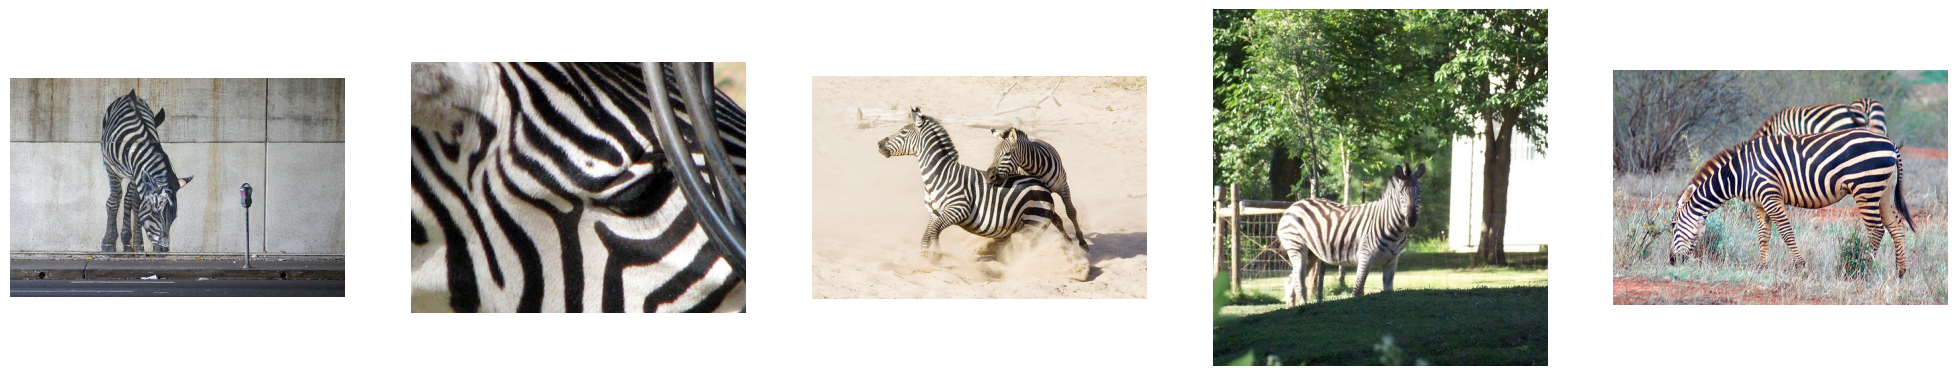

In [ ]:
# Visualizing some of the images

fig, axs = plt.subplots(1, 5, figsize = (25, 5))
axs[0].imshow(zebra_imgs[40])
axs[1].imshow(zebra_imgs[41])
axs[2].imshow(zebra_imgs[34])
axs[3].imshow(zebra_imgs[31])
axs[4].imshow(zebra_imgs[30])

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')
axs[4].axis('off')

plt.show()

In [ ]:
# Load sample images from folder. We select a subset of 40 images.
N = 40
zebra_tensors = torch.stack([transform(img) for img in zebra_imgs[:N]])

## 5.4 – Compute TCAV Scores

Now we have everything ready to compute the TCAV scores for the striped concept and assess its influence on the Zebra class.
The TCAV class provide the `interpret` method which receives as input three arguments:
- the `inputs` for which we want to assess the influence of the concepts (zebra examples)
- the `experimental_sets` on which we want to train our linear classifier
- the `target` class for which we want to compute the concept influence

`n_steps` is only a parameter required by IntegratedGradient instead.

***Warning!***  The execution of this cell may take a while (up to three mins). If you are running on your laptop consider reducing the dimension of the batch size or the size of the datasets in order to decrease the memory impact.

In [ ]:
# zebra class index is 340
zebra_ind = 340

In [ ]:
tcav_scores_w_random = mytcav.interpret(inputs=zebra_tensors,
                                        experimental_sets=experimental_set_rand,
                                        target=zebra_ind,
                                        n_steps=5,
                                       )

## 5.5 – Visualize TCAV Results

In [ ]:
def format_float(f):
    return float('{:.3f}'.format(f) if abs(f) >= 0.0005 else '{:.3e}'.format(f))

def plot_tcav_scores(experimental_sets, tcav_scores):
    fig, ax = plt.subplots(1, len(experimental_sets), figsize = (25, 7))

    barWidth = 1 / (len(experimental_sets[0]) + 1)

    for idx_es, concepts in enumerate(experimental_sets):


        concepts = experimental_sets[idx_es]
        concepts_key = concepts_to_str(concepts)

        pos = [np.arange(len(layers))]
        for i in range(1, len(concepts)):
            pos.append([(x + barWidth) for x in pos[i-1]])
        _ax = (ax[idx_es] if len(experimental_sets) > 1 else ax)
        for i in range(len(concepts)):
            val = [format_float(scores['sign_count'][i]) for layer, scores in tcav_scores[concepts_key].items()]
            _ax.bar(pos[i], val, width=barWidth, edgecolor='white', label=concepts[i].name)

        # Add xticks on the middle of the group bars
        _ax.set_xlabel('Set {}'.format(str(idx_es)), fontweight='bold', fontsize=16)
        _ax.set_xticks([r + 0.3 * barWidth for r in range(len(layers))])
        _ax.set_xticklabels(layers, fontsize=16)

        # Create legend & Show graphic
        _ax.legend(fontsize=16)

    plt.show()

Let's use above defined auxilary functions and visualize tcav scores below.

TCAV scores are shown layer-by-layer for each concept. A **higher score** indicates **stronger influence** of the concept on the prediction

0 0-13
1 0-14


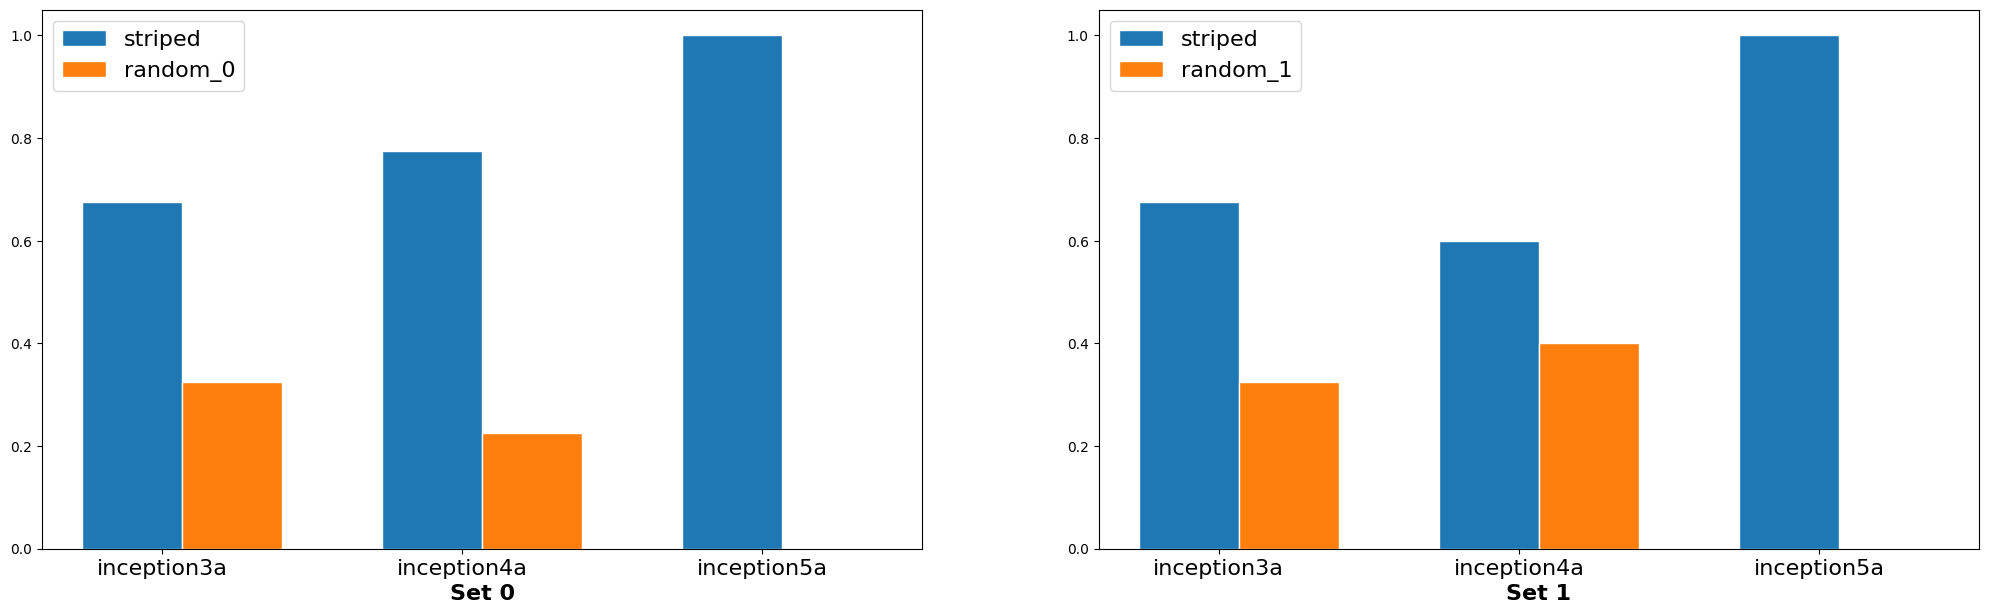

In [ ]:
plot_tcav_scores(experimental_set_rand, tcav_scores_w_random)


We observe that the images that are predicted as `zebra` by the model are very sensitive  to `striped` concept as opposed to any random concept, especially for the late layer Inception 5a.

Inception3a is designed to capture low- to mid-level features.
Inception5a works on more abstract, semantic features, suited to complex pattern recognition near the output stage. Hence, the higher sensitivity to the pattern for the late layer matches the expectation.

## 5.6 –  Relative TCAV Scores

Now, let's compute TCAV scores for a new experimental set that includes three specific concepts: `striped`, `zigzagged`, and `dotted`.

This setup illustrates the idea of **Relative TCAV**.
Unlike the standard TCAV approach—which compares a meaningful concept to a random baseline to ask, *“Does the model use this concept to make predictions?”*—Relative TCAV poses a more refined question:

> *“Does the model rely more on one meaningful concept (e.g., `striped`) than on another (e.g., `zigzagged` or `dotted`)?”*

This allows us to assess not just whether a concept is important, but **how it ranks in importance relative to other semantically plausible alternatives**.



In [ ]:
experimental_set_concepts = [[stripes_concept, zigzagged_concept, dotted_concept]]

In [ ]:
# Estimated time: 3 mins
tcav_scores_w_concepts = mytcav.interpret(inputs=zebra_tensors,
                                         experimental_sets=experimental_set_concepts,
                                         target=zebra_ind,
                                         n_steps=5)

0 0-1-2


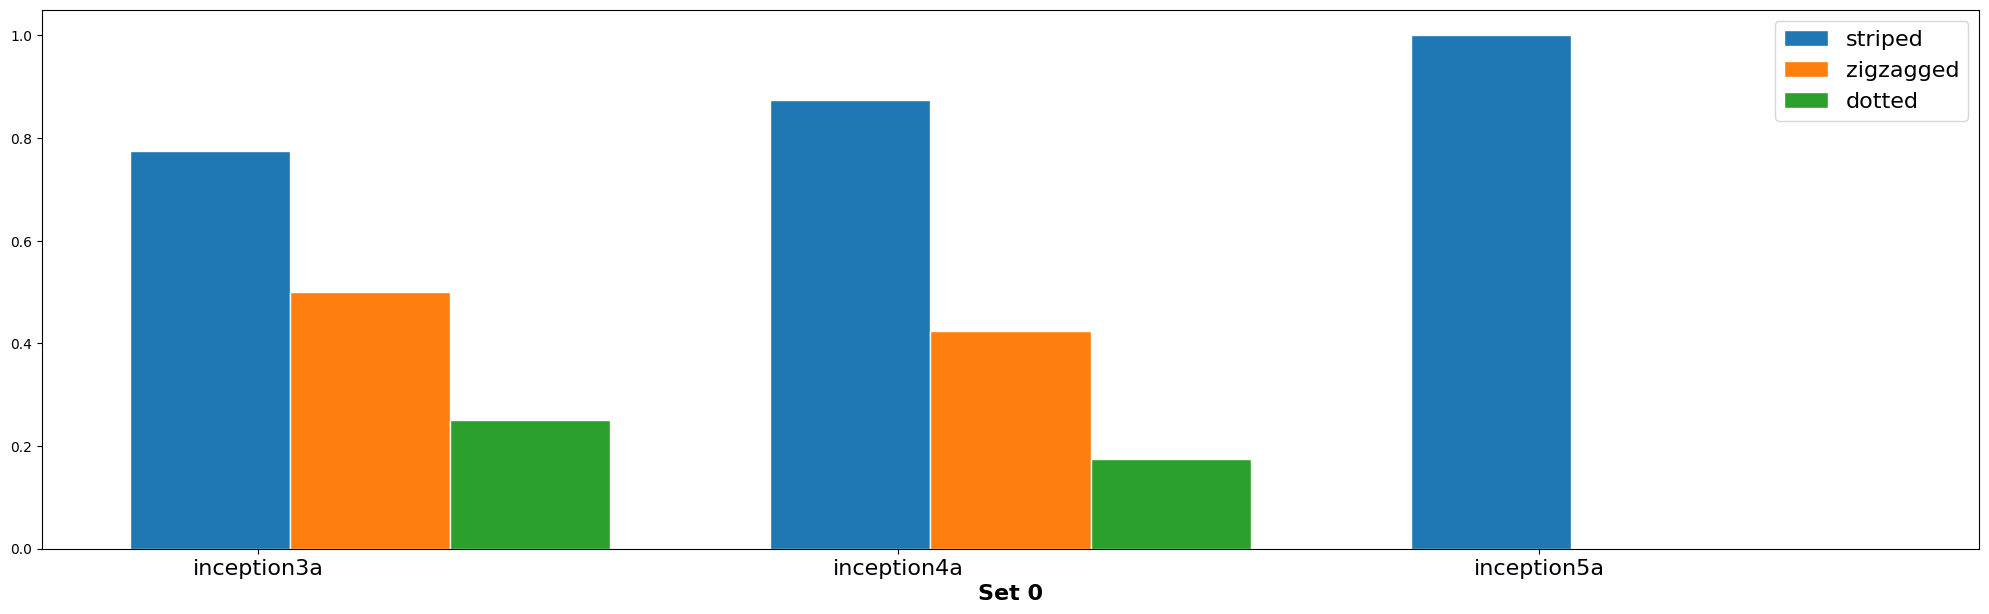

In [ ]:
plot_tcav_scores(experimental_set_concepts, tcav_scores_w_concepts)

# 6. 🖼️ Further analysis of concept influence

In this step, you will perform an **in-depth analysis of concept influence** by exploring and comparing how different types of concepts—such as **colors**, **textures**, and **patterns**—affect model predictions.

You will:

* **Test color concepts** (e.g., `red`, `white`, `black`, etc.) to see if the model relies on visual cues unrelated to zebra appearance.
* **Evaluate alternative texture concepts** (like `chequered`, `banded`, `honeycomb`) to investigate if they compete with or resemble the `striped` concept.

> These analyses help you build **intuitive, hypothesis-driven explanations** for model decisions, and critically assess **what the model is truly focusing on**—even beyond traditional attribution methods.


## 6.1 Analyze color concepts

**Test color concepts** (e.g., `red`, `white`, `black`, etc.) to see if the model relies on visual cues.

Estimated time: 3min.

0 8-6-7-9-11-12


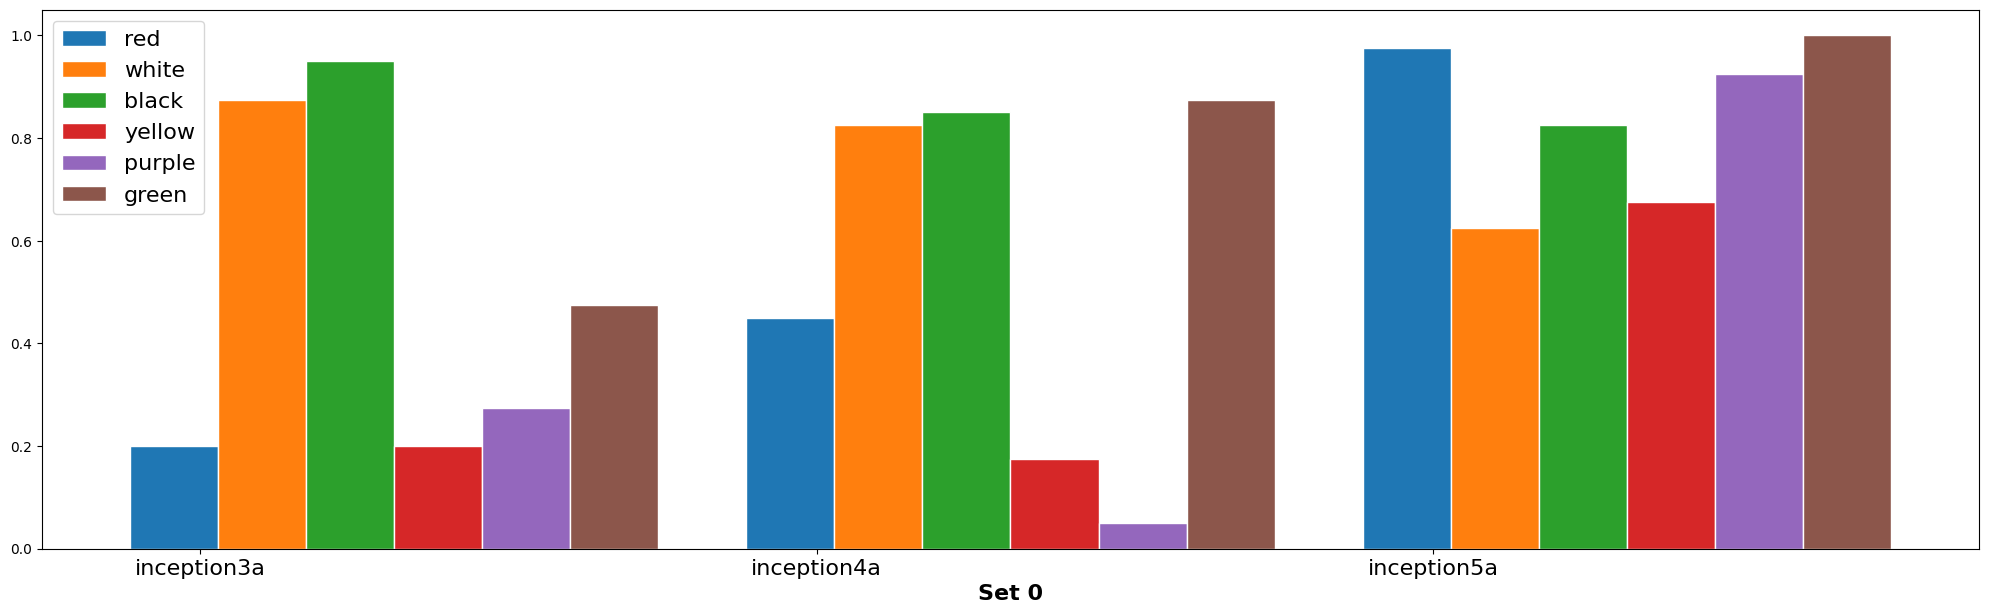

In [ ]:
experimental_set_colors = [[red_concept, white_concept, black_concept, yellow_concept, purple_concept, green_concept]]

tcav_scores_colors  = mytcav.interpret(inputs=zebra_tensors,
                                         experimental_sets=experimental_set_colors,
                                         target=zebra_ind,
                                         n_steps=5)

plot_tcav_scores(experimental_set_colors, tcav_scores_colors)

**✅ Key Observations:**

- Early layers like Inception3a heavily rely on discriminative concepts such as black and white (for stripes) and green (for background), suggesting a reliance on environmental and color cues.

- As we move to deeper layers like inception5a, the model's reliance becomes more distributed across all color concepts, indicating a shift from low-level feature recognition to high-level, abstract  patterns.


## 6.2 – Analyze New Texture Concepts

**Evaluate alternative texture concepts** like `chequered`, `banded`, `honeycomb`.

Estimated time: 3min.

0 0-5-3-4


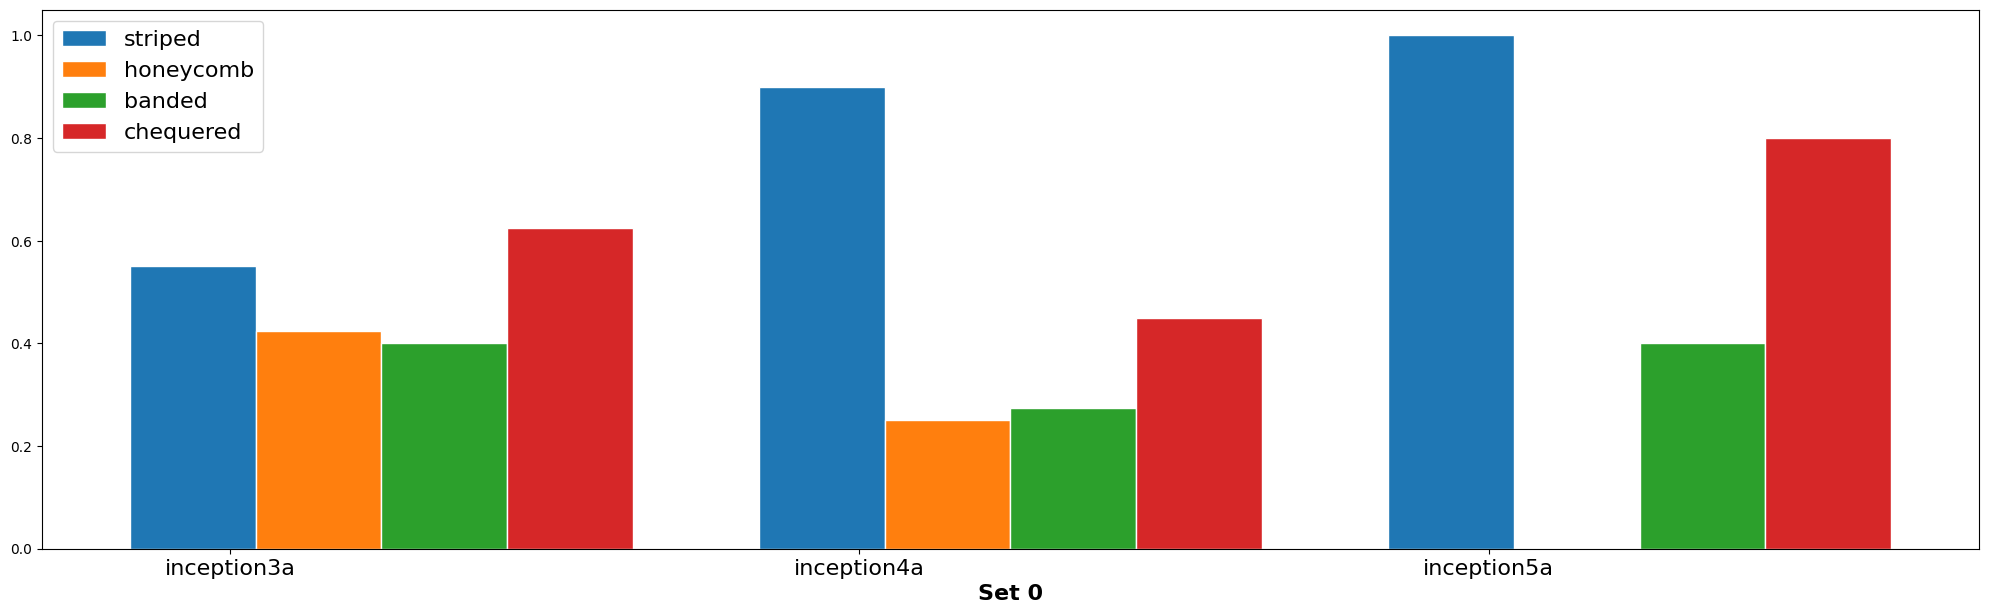

In [ ]:
experimental_set_concepts = [[stripes_concept, honeycomb_concept, banded_concept, chequered_concept]]

tcav_scores_w_concepts = mytcav.interpret(inputs=zebra_tensors,
                                         experimental_sets=experimental_set_concepts,
                                         target=zebra_ind,
                                         n_steps=5)

plot_tcav_scores(experimental_set_concepts, tcav_scores_w_concepts)

**✅ Key Observations:**
- `striped` remains the most influential across all layers — especially dominant at deeper layers (inception4a, inception5a), where it reaches TCAV scores near or at 1.0.

- `chequered` shows some influence, particularly at inception5a, where it nearly matches `striped`. *This is interesting since it also contains repetitive patterns.*

- `banded` and `honeycomb` remain weak overall, with low influence scores in all layers.




> This comparison reinforces that `striped` is the most critical visual concept for the zebra class in the model's internal logic.
While `chequered` comes close in deeper layers, the dominance of `striped` across the entire network reflects strong alignment between the model's learned features and human-interpretable concepts.

